In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline
import torch
import numpy as np
import os
import pickle
import gzip
import pandas
from matplotlib import pyplot as plt
from pathlib import Path
from nuplan.planning.training.preprocessing.features.vector_set_map import VectorSetMap
from nuplan.planning.training.preprocessing.features.generic_agents import GenericAgents
# from nuplan_extent.planning.training.modeling.models.gameformer_model import GameFormer
from nuplan.planning.simulation.trajectory.trajectory_sampling import TrajectorySampling

torch.set_printoptions(threshold=15)

## Statistics

In [2]:
# cache_path = "/mnt/nas20/nuplan_cached/nuplanv1.1_mini_gameformer_20Hz_per1500_alltargets_v2/"
# meta_path = "/mnt/nas20/nuplan_cached/nuplanv1.1_mini_gameformer_20Hz_per1500_alltargets_v2_metadata/nuplanv1.1_mini_gameformer_20Hz_per1500_alltargets_v2_metadata_node_0.csv"
meta_path = "/mnt/nas20/nuplan_cached/nuplanv1.1_gameformer_20Hz_per1500_alltargets_metadata/nuplanv1.1_gameformer_20Hz_per1500_alltargets_metadata_node_0.csv"
list_files = pandas.read_csv(meta_path)

In [3]:
print(f"The total number of scenarios is {len(list_files) // 4}")
scenario_types = {}
set_paths = set([Path(i).parent for i in list_files['file_name'].to_list()])
for path in set_paths:
    stype = path.parents[0].stem
    scenario_types[stype] = scenario_types.get(stype, 0) + 1
scenario_pd = pandas.DataFrame.from_dict(scenario_types, orient='index')
scenario_pd = scenario_pd.rename(columns={0: "count"})
print(scenario_pd)

The total number of scenarios is 27943
                                                    count
on_traffic_light_intersection                         520
traversing_traffic_light_intersection                1500
traversing_pickup_dropoff                            1500
on_pickup_dropoff                                    1500
near_high_speed_vehicle                              1500
traversing_crosswalk                                  632
stationary_in_traffic                                1500
on_intersection                                      1226
on_stopline_traffic_light                             159
stationary                                           1500
medium_magnitude_speed                               1500
stationary_at_traffic_light_without_lead             1500
starting_unprotected_cross_turn                        27
low_magnitude_speed                                  1219
near_pedestrian_on_crosswalk                          349
traversing_intersection          

## Data details
---
There are 4 files for each scenario: 

* **generic_agents.gz** has the past trajectories of both ego and other agents. has shape \[21, num_agents, 11\] for each category
    * The 11 features are: x, y, heading, vx, vy, length, width, height, is_vehicle, is_pedestrian, is_bicycle
    * The 21 timesteps are: past 2s * 10Hz + 1 current position
* **agents_trajectory_target.gz** has the future trajectories of other agents. has shape \[16, num_agents, 3\]
    * The 16 timesteps are: future 8s * 2Hz
* **vector_set_map.gz** has the map features.
    * coords: coordinate data of selected map objects
        * LANE: \[num_obj, num_points, 4\] representing x, y, heading, speed_limit
        * LEFT_BOUNDARY \[num_obj, num_points, 2\] representing x, y
        * RIGHT_BOUNDARY \[num_obj, num_points, 2\] representing x, y
        * STOP_LINE \[num_obj, num_points, 2\] representing x, y
        * CROSSWALK \[num_obj, num_points, 2\] representing x, y
        * ROUTE_LANES \[num_obj, num_points, 2\] representing x,y
    * traffic_light_data: traffic_light_data of selected map objects
        * LANE: \[num_obj, num_points, 4\] representing green, yellow, red, unknown
    * availabilities: whether a point is valid or not
* **trajectory.gz** has the future trajectory of ego agent. \[16, 3\]

---

## Data visualization

In [4]:
path = "/mnt/nas20/nuplan_cached/nuplanv1.1_mini_gameformer_20Hz_per1500_alltargets_v2/2021.06.03.12.02.06_veh-35_00233_00609/unknown/b36cb91e1495574c/"
agents_past_data = os.path.join(path, "generic_agents.gz")
agents_future_data = os.path.join(path, "agents_trajectory_target.gz")
ego_target_data = os.path.join(path, "trajectory.gz")
map_data = os.path.join(path, "vector_set_map.gz")

In [5]:
with gzip.open(agents_past_data, "rb") as f:
    past = pickle.load(f)
    
with gzip.open(agents_future_data, "rb") as f:
    future = pickle.load(f)
    
with gzip.open(ego_target_data, "rb") as f:
    ego_future = pickle.load(f)

with gzip.open(map_data, "rb") as f:
    maps = pickle.load(f)

(-99.66369132995605, 72.14926414489746, -13.16212248802185, 51.43179965019226)

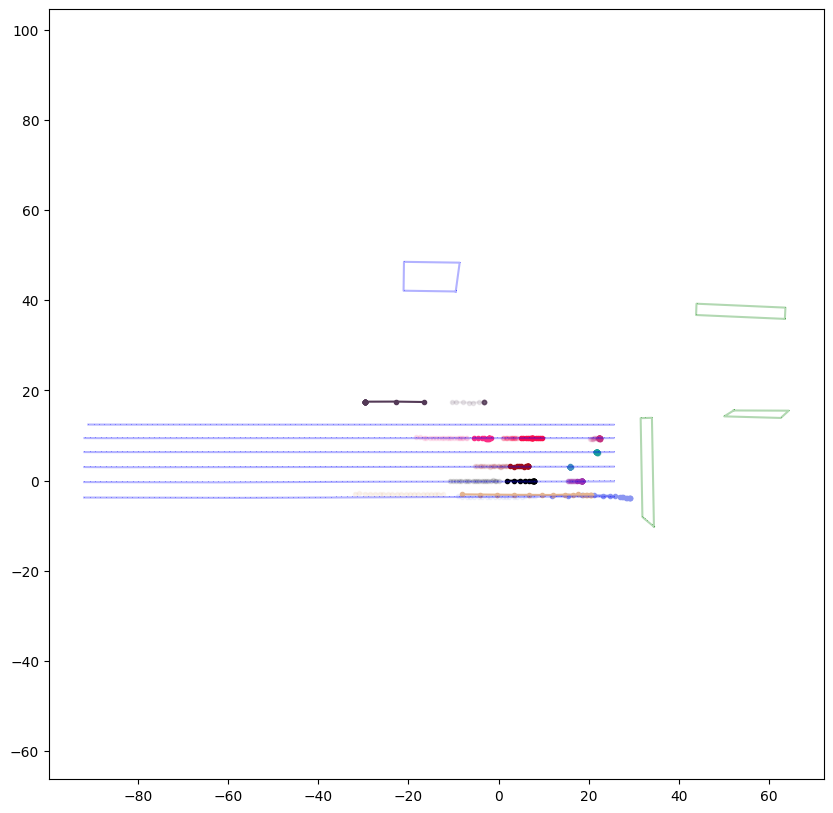

In [6]:
plt.figure(figsize=(10,10))

for agent in ['VEHICLE', 'PEDESTRIAN', 'BICYCLE']:
    num_vehicle = past['agents'][agent][0].shape[1]
    for i in range(num_vehicle):
        color = np.random.rand(3,)
        
        vehicle = past['agents'][agent][0][:, i, :2]
        plt.plot(vehicle[:, 0], vehicle[:, 1], '.-', c=color, alpha=0.1)
        
        vehicle_future = future['agents'][agent][0][:, i, :2]
        plt.plot(vehicle_future[:, 0], vehicle_future[:, 1], '.-', c=color)

# Ego track
plt.plot(past['ego'][0][:, 0], past['ego'][0][:, 1], 'k.-', alpha=0.1)
plt.plot(ego_future['data'][:, 0], ego_future['data'][:, 1], 'k.-')

# Map data
for lane in maps['coords']['LANE'][0]:
    plt.plot(lane[:, 0], lane[:, 1], 'b,-', alpha=0.3)
for lane in maps['coords']['CROSSWALK'][0]:
    lane = lane[lane[:, 0]!=0]
    plt.plot(lane[:, 0], lane[:, 1], 'b,-', alpha=0.3)
for lane in maps['coords']['STOP_LINE'][0]:
    lane = lane[lane[:, 0]!=0]
    plt.plot(lane[:, 0], lane[:, 1], 'g,-', alpha=0.3)
plt.axis('equal')

## Things to note
There are scenarios where the number of other agents is less than 10. The following provides an example. You can see there are only 8 agents

In [7]:
for path in set_paths:
    agents_past_data = os.path.join(path, "generic_agents.gz")
    agents_future_data = os.path.join(path, "agents_trajectory_target.gz")
    with gzip.open(agents_past_data, "rb") as f:
        past = pickle.load(f)
    with gzip.open(agents_future_data, "rb") as f:
        future = pickle.load(f)
    if past['agents']['VEHICLE'][0].shape[1] + past['agents']['PEDESTRIAN'][0].shape[1] + past['agents']['BICYCLE'][0].shape[1] < 10:
        break

In [8]:
print("=====past=====")
for key, val in past['agents'].items():
    print(key, val[0].shape)
print("=====future=====")
for key, val in future['agents'].items():
    print(key, val[0].shape)
print("=====ego future=====")
print(ego_future['data'].shape)

=====past=====
VEHICLE (21, 6, 11)
PEDESTRIAN (21, 1, 11)
BICYCLE (21, 0, 11)
=====future=====
VEHICLE (16, 6, 3)
PEDESTRIAN (16, 1, 3)
BICYCLE (16, 0, 3)
=====ego future=====
(16, 3)


## Sample code used by GameFormer to pack incoming data

In [9]:
# self.num_other_agents = 10
# self.input_agent_dim = 11
# self.past_trajectory_sampling.num_poses = 20

from nuplan.planning.training.preprocessing.features.generic_agents import (
    GenericAgents,
)
from nuplan.planning.training.preprocessing.features.vector_set_map import (
    VectorSetMap,
)
from nuplan.planning.training.modeling.types import FeaturesType, TargetsType

def process_map_data_to_tensors(self, features: FeaturesType):
    vector_set_map: VectorSetMap = features["vector_set_map"]
    lane_coords = torch.stack(vector_set_map.coords["LANE"], dim=0)
    left_boundary = torch.stack(
        vector_set_map.coords["LEFT_BOUNDARY"], dim=0
    )
    right_boundary = torch.stack(
        vector_set_map.coords["RIGHT_BOUNDARY"], dim=0
    )
    traffic_light_status = torch.stack(
        vector_set_map.traffic_light_data["LANE"], dim=0
    )

    lane = torch.cat(
        [lane_coords, left_boundary, right_boundary, traffic_light_status],
        dim=-1,
    )
    lane_mask = torch.stack(vector_set_map.availabilities["LANE"], dim=0)

    stopline_and_crosswalk = torch.cat(
        [
            torch.stack(vector_set_map.coords["STOP_LINE"], dim=0),
            torch.stack(vector_set_map.coords["CROSSWALK"], dim=0),
        ],
        dim=1,
    )
    stopline_and_crosswalk_mask = torch.cat(
        [
            torch.stack(vector_set_map.availabilities["STOP_LINE"], dim=0),
            torch.stack(vector_set_map.availabilities["CROSSWALK"], dim=0),
        ],
        dim=1,
    )

    return {
        "lane": lane.unsqueeze(1),
        "lane_mask": lane_mask.unsqueeze(1),
        "stopline_crosswalk": stopline_and_crosswalk.unsqueeze(1),
        "stopline_crosswalk_mask": stopline_and_crosswalk_mask.unsqueeze(
            1
        ),
    }

def process_agent_data_to_tensors(self, features: FeaturesType):
    # anchor is at the last position
    agent_features: GenericAgents = features["generic_agents"]
    batch_size = agent_features.batch_size

    batched_other_agents = []
    batched_other_agents_mask = []
    batched_ego = torch.stack(agent_features.ego, dim=0)
    for i in range(batch_size):
        # ego features
        anchor_ego = agent_features.ego[i][
            -1, :2
        ]  # x,y of current position
        # agent features
        all_other_agents = []
        if agent_features.has_agents("VEHICLE", i):
            all_other_agents.append(agent_features.agents["VEHICLE"][i])
        if agent_features.has_agents("PEDESTRIAN", i):
            all_other_agents.append(agent_features.agents["PEDESTRIAN"][i])
        if agent_features.has_agents("BICYCLE", i):
            all_other_agents.append(agent_features.agents["BICYCLE"][i])

        num_agents_to_pad = -1
        other_agents_tensor = None
        if len(all_other_agents) > 0:
            other_agents_tensor = torch.cat(all_other_agents, dim=1)

            if other_agents_tensor.shape[1] < self.num_other_agents:
                num_agents_to_pad = (
                    self.num_other_agents - other_agents_tensor.shape[1]
                )
                other_agents_tensor = torch.nn.functional.pad(
                    other_agents_tensor,
                    (0, 0, 0, num_agents_to_pad, 0, 0),
                    mode="constant",
                    value=0.0,
                )
            else:
                num_agents_to_pad = 0
        else:
            other_agents_tensor = torch.zeros(
                anchor_ego.shape[0],
                self.num_other_agents,
                self.input_agent_dim,
            ).type_as(anchor_ego)
            num_agents_to_pad = self.num_other_agents

        expected_timesteps = self.past_trajectory_sampling.num_poses + 1
        num_timesteps_to_pad = (
            expected_timesteps - other_agents_tensor.shape[0]
        )
        if num_timesteps_to_pad > 0:
            # NOTE: current state is at the last position,
            # so to pad in time dimension, we pad from the front.
            other_agents_tensor = torch.nn.functional.pad(
                other_agents_tensor,
                (0, 0, 0, 0, num_timesteps_to_pad, 0),
                mode="constant",
                value=0.0,
            )

        avail = torch.ones(
            other_agents_tensor.shape[0],
            other_agents_tensor.shape[1],
            dtype=torch.bool,
            device=other_agents_tensor.device,
        )
        if num_agents_to_pad > 0:
            avail[:, -num_agents_to_pad:] = False
        if num_timesteps_to_pad > 0:
            avail[:num_timesteps_to_pad, :] = False
        batched_other_agents.append(other_agents_tensor)
        batched_other_agents_mask.append(avail)

    return {
        "ego": batched_ego.unsqueeze(1),
        "agents": torch.stack(batched_other_agents, dim=0).transpose(1, 2),
        "agents_mask": torch.stack(
            batched_other_agents_mask, dim=0
        ).transpose(1, 2),
    }